# Aufgabe 3b

## Notebook description
...

## Bibliotheken importieren und Notebook setup

In [70]:
# Modul Pfad setzen
import sys
sys.path.append('./module')


# Bibliotheken importieren
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error

from scipy import stats

from IPython.display import display


## Analyse und Datenvorverarbeitung


In [71]:
# Load Dataset from csv
data = pd.read_excel("./data/Growth.xlsx")
# Display first line to test if data was loaded correctly
display(data.head())
print(data.shape)

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,0,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,0,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333


(65, 8)


### Analyse der Zielvariable growth

Die Spalte "growth" beschreibt das durchschnittliche jährliche Wachstum des GDP in Prozent (von 1960 bis 1995) und ist die Zielvariable die vorhergesagt werden soll. Die Variable ist kontinuierlich. Somit hadelt es sich um ein Regressionsproblem.

In [52]:
target_variable = "growth"
# calculate row with max growth
highest_gdp_growth = data.loc[data[target_variable].idxmax()]
# calculate row with min growth
lowest_gdp_growth = data.loc[data[target_variable].idxmin()]
# print results
print("{country_name} has the highest gdp growth with {growth:.2f}%".format(**highest_gdp_growth))
print("{country_name} has the lowest gdp growth with {growth:.2f}%".format(**lowest_gdp_growth))

Korea, Republic of has the highest gdp growth with 7.16%
Zaire has the lowest gdp growth with -2.81%


Korea hat mit 7.16 % das höchste GDP Wachstum. In Zaire gab es hingegen einen Rückgang von 2.81% was der geringste Wert ist. 

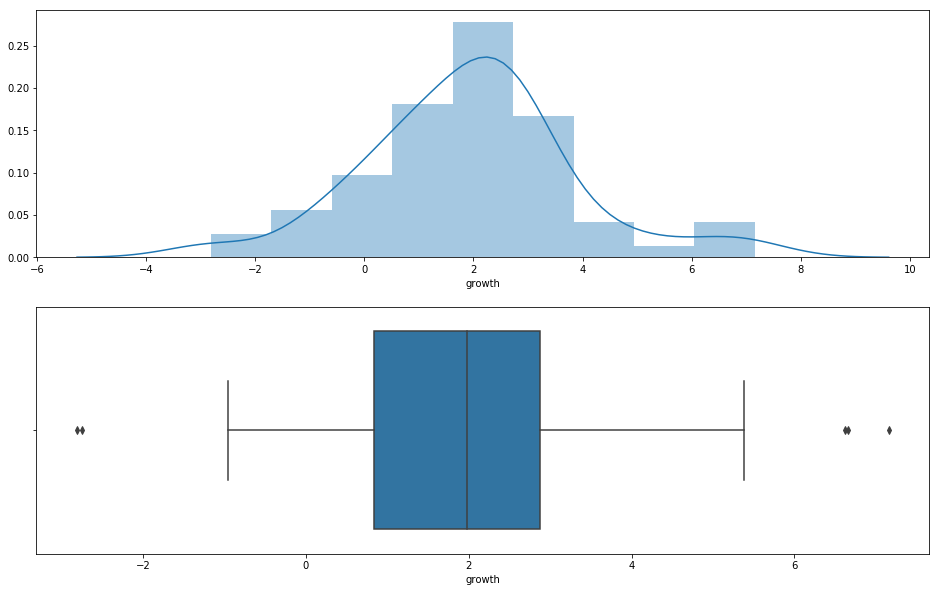

Mean: 1.9427153966747797
Std:  1.8971197622279778
Skewness:  0.2546346792074454
Kurtosis:  1.2689666991505941


In [69]:
##### plot distribution plot of growth variable
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
sns.distplot(data[target_variable], bins=9)
plt.subplot(2,1,2)
# x-Achse skalierung
sns.boxplot(data[target_variable])
plt.show()
print("Mean:", data[target_variable].mean())
print("Std: ", data[target_variable].std())
print("Skewness: ", data[target_variable].skew())
print("Kurtosis: ", data[target_variable].kurt())

Im obigen Plot ist die Verteilung der Zielvariable "growth" zu sehen. Diese sieht annähernd wie eine Normalverteilung mit dem Mittelwert bei 2% aus. Die niedrige Skewness unterstützt diese Aussage, wohingegen eine Kurtosis über eins eher dagegen spricht. Dies ist durch die vielen Ausreißer zu erklären, die ein Wachstum von mehr als 6% haben. Diese lassen sich gut auf dem Boxplot erkennen.

### Analyse der Features

In [54]:
# define feature columns
features = ["oil", "rgdp60", "tradeshare", "yearsschool", "rev_coups", "assasinations"]
# display first few rows
display(data[features].head())
# print number of features
print("Anzahl der Feautres:", len(features))

,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,0,765.999817,0.140502,1.45,0.133333,0.866667
1,0,4462.001465,0.156623,4.99,0.933333,1.933333
2,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,0,1783.999878,0.160405,2.89,0.100000,0.100000
4,0,9895.003906,0.160815,8.66,0.000000,0.433333


Anzahl der Feautres: 6


Jeder Datenpunkt besteht aus sechs merkmalen. Das Merkmal "oil" ist ein nominalskaliertes kategorisches Merkmal, da nur die Werte 0 und 1 erlaubt sind und zwischen diesen keine Reihenfolge besteht. Die anderen fünf Merkmale sind kontinuierlich und verhältnisskaliert. Das Bedeutet, dass sie einen absoluten Nullpunkt besitzten und sie in ein Verhältnis gestellt werden können (z.B. doppelt so groß).

Zunächst wird nun das einzige kategorische Merkmal betrachtet, da es möglicherweise transformiert werden muss.

In [55]:
# count different values of oil
data.groupby("oil").size()

oil
0    65
dtype: int64

Der Wert für "oil" ist immer 0. Dieses Merkmal liefert daher keine Informationen und kann ignoriert werden. Die Spalte wird aus der Liste der Merkmale gelöscht.

In [56]:
# drop feature "oil"
features.remove("oil")

Die anderen Merkmale sind alle kontinuierlich. Um einen Überblick zu bekommen wird für alle Minimum, Maximum, Durchschnitt und Standardabweichung berechnet.

In [74]:
# show min, max, mean and standard deviation of continious features
display(data[features].aggregate(["min", "max", "mean", "std"]))
display(data[data["tradeshare"]>1.9][["country_name", "tradeshare"]])

,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
min,366.999939,0.140502,0.200000,0.00000,0.000000
max,9895.003906,1.992616,10.070000,0.97037,2.466667
mean,3103.784649,0.564703,3.985077,0.16745,0.277564
std,2512.656846,0.289270,2.542000,0.22468,0.491528


,country_name,tradeshare
64,Malta,1.992616


Dieser erste Überblick zeigt, dass das Merkmal "rgdp60" betragsmäßig sehr viel größer ist als die anderen Merkmale. Dies kann zu Problemen beim Training führen. Daher ist es sehr wichtig alle Merkmale vor dem Training zu normalisieren.  
Bei dem Merkmal "tradeshare" fällt der sehr hohe Wert von fast 2 auf, den das Land Malta besitzt. Die Summe der Importe und Exporte ist dort doppelt so groß wie das GDP. 
Um genaure Einsichten in die Verteilung der Merkmale zu gewinnen, wird jeweils ein Histogramm und ein Boxplot erstellt.

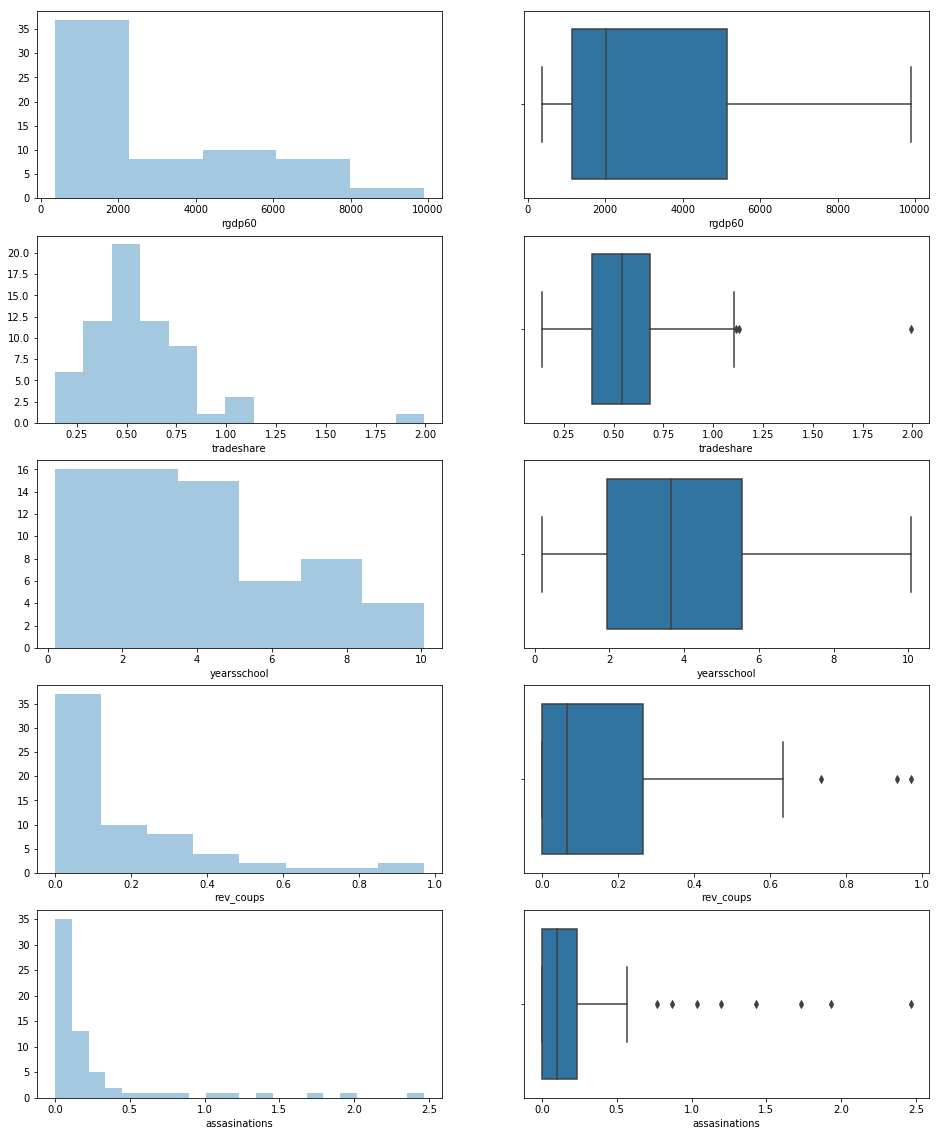

In [72]:
# set figure size
plt.figure(figsize=(16, len(features) * 4))
# create grid with one row for each feature
gs = plt.GridSpec(len(features), 2)
# iterate all feautres
for i, col in enumerate(features):
    # draw histogram
    ax = plt.subplot(gs[i,0])
    sns.distplot(data[col], kde=False)
    # draw boxplot
    ax = plt.subplot(gs[i,1])
    sns.boxplot(data[col])

Im obersten Plot ist zu erkennen, dass die meisten Länder ein durchschnittliches GDP zwischen 0 und 2000 USD besitzen und einige weitere Länder gibt, die ein höheres GDP gibt. Hierbei gibt es allerdings keine extremen Ausreißer, die sich von den anderen Werten sehr stark unterscheiden. Dies ist auch im Boxplot zu sehen.  
Im Plot des Merkmals "tradeshare" ist, wie zuvor besprochen, Malta mit einem Wert von fast 2 zu sehen. Auf dem Boxplot ist nochmals zu erkennen, wie weit Malta damit von allen anderen Ländern entfernt ist und somit einen extremen Ausreißer darstellt. Man könnte überlegen diesen Datenpunkt deshalb zu entfernen. Aufgrund der bereits sehr geringen Menge an Trainingsdaten wurde sich aber dagegen entschieden.  
Eine weitere Anzahl von hohen Ausreißern ist bei "rev_coups" und vorallem bei "assasinations" zu sehen. Dies ist allerdings zu erwarten, da es in den aller meisten Ländern weder zu Revolutionen noch zu Attentaten kommt und somit politisch unstabile Länder zu ausreißern werden.

Um eine mögliche Beziehung zwischen den gegebenen Merkmalen und der Zielvariable zu bestimmen, wird ein Punktdiagramm für jedes Merkmal erstellt. 

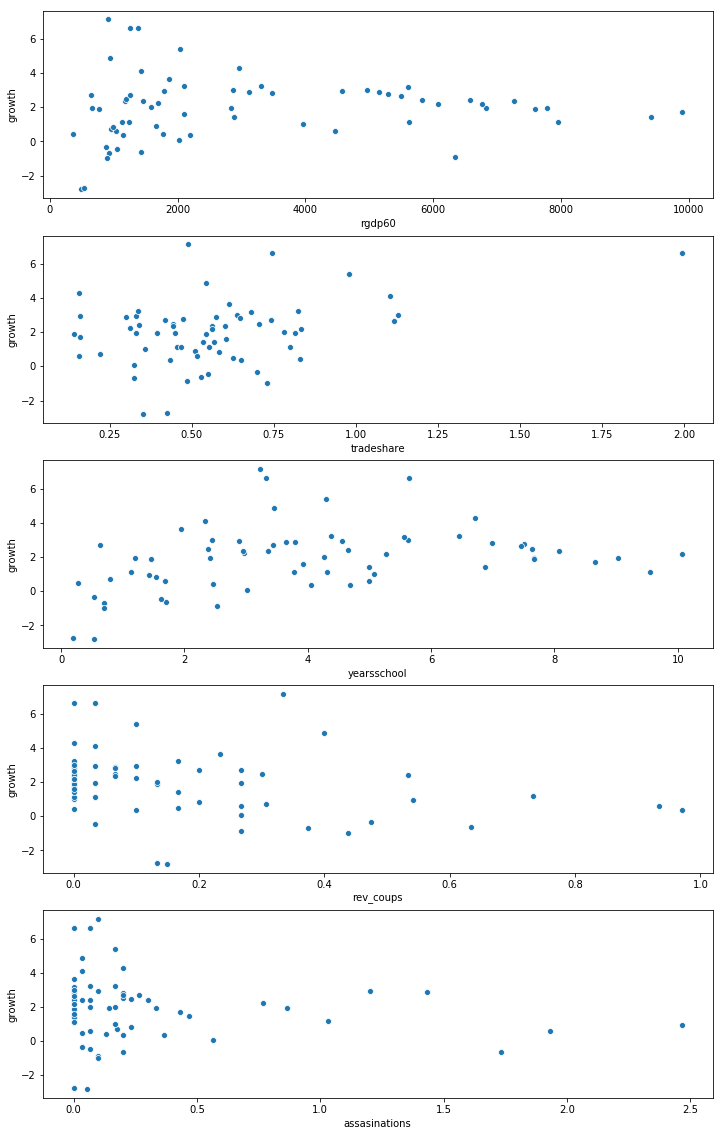

In [59]:
# set figure and grid size
plt.figure(figsize=(12, len(features) * 4))
gs = plt.GridSpec(len(features), 1)
# greate scatter plot for each feature with feature on the x-axis and target variable on the y-axis
for i, feature in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.scatterplot(data[feature], data[target_variable])

Der erste Plot stellt den Zusammenhang zwischen dem absoluten GDP in 1960 und dem durchschnittlichen GDP Wachstum zwischen 1960 und 1995 dar. Es fällt auf, dass Länder mit einem geringen GDP die höchsten und gleichzeitig auch die Niedrigsten Wachstumsraten haben. Je höher das initiale GDP, desto näher pendelt sich das Wachstum der Länder bei ca. 2% ein. Dies macht Sinn, da Länder mit einem geringen GDP mehr "Raum nach oben" haben und ein starker Wachstum realitisch ist. Gleichzeitig kann es für Länder mit einem geringen GDP schwierig sein, sich wirtschaftlich zu entwickeln und somit kaum Wachstum erziehlen. Für ein Land, welches bereits eine funktionierende Wirtschaft mit einem hohen GDP hat, ist ein Wachstum leichter zu erziehlen. Allerdings ist dieses dann nicht so extrem wie das von Entwicklungsländern. Allgemein gibt es also eine Abhängigkeit zwischen initialem GDP und wachstum, diese ist aber nicht linear.  
Bei "tradeshare" und "yearschool" scheint es eine leichte positive Korrelation zu geben, allerdings sind die Datenpunkte sehr verstreut und bilden keine klare Gerade. Die Merkmale "rev_coups" und "assasinations" haben hingegen eher eine negative Korrelation mit dem Wachstum.  
Um diese Korrelationen genauer zu untersuchen und auch mögliche Multikollinearität zu finden wird im Folgenden eine Korrelationsmatrix erstellt.  

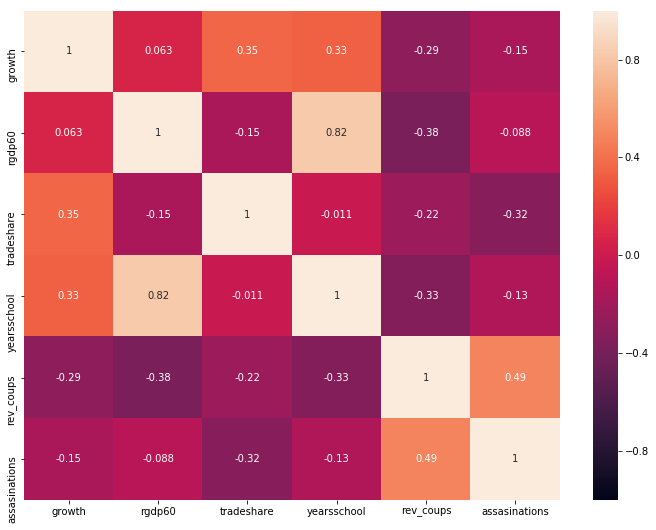

In [60]:
# create correlation matrix of target variable and feaures
correlation_matrix = data[[target_variable] + features].corr()
# set figure size
fig = plt.figure(figsize=(12,9))
# visualize correlation matrix as heatmap
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True)
plt.show()

Wie zuvor schon aus dem Punktdiagramm gelesen wurde beeinflussen "trageshare" und "yearschool" das Wachstum jeweils positiv. Die Korrelation ist mit 0.35 und 0.33 allerdings nicht besonders hoch. Auch die negative Korrelation von "rev_coups" und "assasinations" mit dem Wachstum kann aus der Matrix entnommen werden, allerdings ist diese noch geringer.  
Abgesehen davon sticht die hohe Korrelation von "rgdp60" und "yearschool" mit 0.82 heraus. Da Länder mit einem hohen GDP meist schon hoch entwickelte Industriestaaten sind, ist hier auch die Schulzeit meist hoch, da gut ausgebildete Fachkräfte benötigt werden. Diese hohe Multikollinearität sollte bei der Modellauswahl berücksichtigt werden.

### Train/Test split erstellen

Die Daten werden in 80% Trainingsdaten und 20% Testdaten separiert

In [83]:
# Create numpy arrays for features and target
X = data[features].to_numpy()
y = data[target_variable].to_numpy()
# Create 80/20 train val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
# Print resulting dataset sizes
print("Shape X_train", X_train.shape)
print("Shape y_train", y_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_test", y_test.shape)

Shape X_train (52, 5)
Shape y_train (52,)
Shape X_test (13, 5)
Shape y_test (13,)


Die Merkmale des Datensatzes sind unterschiedlich skaliert. So sind die Beträge des Merkmals rgdp60 sehr viel größer als die der anderen Merkmale. Eine Möglichkeit dies zu beheben ist das Abziehen des Mittelwertes und anschließendes Teilen durch die Varianz für jedes Merkmal. Dies kann durch die sklearn Klasse StandardScaler umgesetzt werden. Bei der Datenalalyse hat sich allerdings herausgestellt, dass es bei einigen Merkmalen extreme Ausreißer gibt. Diese Beeinflussen den Mittelwert und Varianz stark, wodurch eine suboptimale Skalierung durch den StandardScaler entstehen kann. Daher wird im Folgenden der RobustScaler verwendet, welcher ähnlich wie der StandardScaler funktioniert, allerdings robust gegenüber Ausreißern ist, da der Median und Interquartilsabstand statt Mittelwert und Varianz verwendet wird. (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

In [84]:
# Use StandardScaler to transform data to zero mean and unit variance
sc = RobustScaler()
# Fit and transform on training data
X_train = sc.fit_transform(X_train)
# Only apply transformation to test data
X_test = sc.transform(X_test)

## Modellauswahl und -training

Es gibt viele Regressionsmodelle, die für die Vorhersage des GDP-Wachstums verwendet werden können. Da die Zielvariable annähernd normalverteilt ist könnte eine lineare Regression ausprobiert werden.
Diese ist allerdings anfällig gegenüber ausreißern und kann zu Problemen bei Multikollinearität führen. Daher kommen regularisierte Regreionsmodelle in Frage, die diese Probleme reduzieren. Hierzu gehören zum Beispiel:
- Lasso-Regression mit L1 Regularisierung
- Ridge-Regression mit L2 Regularisierung
- ElasticNet-Regression mit L1 und L2 Regularisierung


Nachteil ist bei diesen Modellen allerdings, dass es Hypterparameter gibt, die gesetzt werden müssen.
Um auch nicht lineare Abhängigkeiten abbilden zu können, könnte auch ein nicht lineares Modell eingesetzt werden. Zum Beispiel eine SVM mit RBF-Kernel.


Um die Performance der Modelle bestimmen zu können, gibt es verschiedene Metriken, die bei einem Regressionsproblem angewendet werden können. Im folgenden wird der root of mean squared error (RMSE) verwendet. Dieser ist leicht zu interpretieren, da die Einheit gleich mit der Zielvariable ist. Alternativ hätte zum Beispiel auch der $R^2$ score verwendet werden können.


Die oben aufgelisteten Modelle werden jeweils auf dem Trainingsdatensatz getestet, um zu entscheiden welches Modell danach weiter verwendet werden soll. Hierfür wird n-fold cross validation verwendet. Dabei wird der Trainingsdatensatz mehrmals zufällig in einen Trainings- und Validationdatensatz aufgeteilt und jeweils das Modell evaluiert.

In [85]:
# Helper function that performs cross validation for a given model and a data set with labels
def cross_validate_model(model, X, y):
    # perform cross validation and use negative mean squared error as score
    scores = cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error")
    # convert score to RMSE
    scores = np.sqrt(-scores)
    # print result
    print("{:16}: average score: {:.2f} variance: {:.3f}".format(model.__class__.__name__, scores.mean(), scores.var()))

In [87]:
# Models to evaluate on
model_candidates = [
    LinearRegression(),
    Lasso(alpha=0.01),
    ElasticNet(),
    Ridge(),
    svm.SVR(kernel="rbf", gamma='auto')
]
# evaluate each model
for model in model_candidates:
    cross_validate_model(model, X_train, y_train)

LinearRegression: average score: 1.59 variance: 0.240
Lasso           : average score: 1.60 variance: 0.243
ElasticNet      : average score: 1.72 variance: 0.456
Ridge           : average score: 1.58 variance: 0.269
SVR             : average score: 1.62 variance: 0.530


Das Ergebnis der Cross Validation mit den verschiedenen Modellen zeigt, dass die lineare Regression den besten durchschnittlichen Score erreicht und auch die Varianz am geringsten ist. Obwohl die lineare Regression das einfachste Modell ist und von Ausreißern und Multikollinearität negativ beeinflusst wird, liefert dieses Modell das beste Ergebnis. Dies liegt auch daran, dass für die anderen Modelle Hyperparameter existieren, die hier nicht optimiert wurden (z.B. durch grid search).   
Im Folgenden wird daher die lineare Regression für eine Evaluation auf dem Testdatensatz verwendet und mit der Baseline verglichen.

## Model evaluation

Zur Evaluation des gewählten Modells wird es auf den gesamten Trainingsdaten trainiert und danach auf den Testdaten der erreichte Score berechnet. Zum Vergleich wird auch der Score des vorgegebenen Baseline Modells verwendet, welches immer das Durchschnittliche Wachstum im Traingsdatensatz vorher sagt.

In [88]:
# Create linear regression model and train it
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
lr_prediction = lr.predict(X_test)
# Calculate RMSE score on predictions
lr_test_score = np.sqrt(mean_squared_error(y_test, lr_prediction))
print("Linear regression test score (RMSE):", lr_test_score)

Linear regression test score: 1.549316491249273


In [89]:
# Create predictions by predicting the mean growth of the train set for each entry in the test set
mean_prediction = np.repeat(y_train.mean(), y_test.shape[0])
# Calculate RMSE score on predictions
mean_test_score = np.sqrt(mean_squared_error(y_test, mean_prediction))
print("Baseline (predict mean) test score (RMSE):", mean_test_score)

Baseline (predict mean) test score: 2.031266318633236


Es ist zu sehen, dass das lineare Regressionsmodell mit 1.55 einen besseren Score erreicht als die Baseline. Um das Ergebnis der linearen Regression weiter zu analysieren, wird im Folgenden das Residuum der Vorhersagen in einem Plot visualisiert. Auf der x-Achse sind die vorhergesagten Werte aufgetragen und auf der y-Achse jeweils der Fehler zum korrekten Wert.

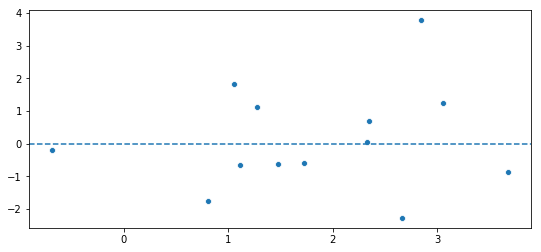

In [90]:
fig = plt.figure(figsize=(9,4))
# Create scatter plot with predictions on the x-axis and residuals on the y-axis
sns.scatterplot(lr_prediction, y_test - lr_prediction)
# Draw horizontal line through y=0
plt.gca().axhline(linestyle="--")
plt.show()

In dem Plot ist zu erkennen, dass ungefähr gleich viele Punkte über und unter der Linie liegen und es kein sichtbares Muster gibt. Dies deutet darauf hin, dass die lineare Regression ein gutes Modell gelernt hat, welches nicht leicht verbessert werden kann. Es fällt allerdings auch auf, dass es nur sehr wenige Datenpunkte im Testdatensatz gibt. Dies liegt daran, dass der komplette Datensatz nur aus 65 Datenpunkten besteht. Bei so wenigen Daten kann es bei einer zufälligen Aufteilung von Trainings- und Testdatensatz dazu kommen, dass die Verteilung des Traingsdatensatzes nicht der des Testdatensatzes entspricht. Diese Annahme wird bei dem Training von Modellen aber gemacht. Bei einer anderen Aufteilung der Trainings und Testdaten ist das Ergebnis also möglicherweise sehr unterschiedlich.